In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D

import pandas as pd
import time
import shutil
import argparse
import numpy as np
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
import sys
# sys.path.append('/DATA/lucaa/software/CLoNe')
# from clone import CLoNe
# from plot import plot_clusters
# from structural_utils import load_md_args, show_cluster_info

# from matplotlib import rc
# plt.rcParams['ps.useafm'] = True
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

import mdtraj
import pyemma
import seaborn as sns
print(__doc__)
start = time.time()

Automatically created module for IPython interactive environment


In [3]:
# PARAMETERS SETUP

# Clustering parameters 
pdc=8   # neighbour search during clusterint
n_resize=4 
filt=0.1 
verbose=False
n_pca=10 # number of PC to include in calculations 
n_bins= 200  # number of bins for PC hist
# Simulations and topology 
trj_apo='traj_cert_apo.xtc'   # apo traj
trj_mut='traj_mut_apo.xtc'  # holo traj
trj_holo='trjcat_cert_holo_fit_CA.xtc'
# trj_tot='traj_cert_tot.xtc'   # concatenated total traj
trj_tot2='cert_apo_holo.xtc'   # concatenated total traj
trj_mtot='mut_holo.xtc'
trj_mtot2='apo5p_holo5p.xtc'

topo_apo='apo_wt_ca.gro'  # pdb or gro of apo

# Selection for PCA calculation (see mdtraj syntax)
at_sel="name CA and residue 423 to 594 and (not residue 507 to 517)"  # try to exclude end loops or regions that move but are not interesting (hides the true PC)
n_res=161   # number of residues (still manual insertion, i know...)
feat="None"
resmin=423
resmax=594
output_folder = "results_holo5p"

apo_name="apo"
holo_name="holo"
mut_name="mut"
tot_name="tot"
tot2_name="tot2"
mtot_name="mtot"

In [4]:
def calculate_pca(topo, traj, main_folder, syst, at_sel, n_pca ):
    # Load trajectory
    topology = mdtraj.load(topo).topology
    struct_ens = mdtraj.load(traj, top=topo)

    # Create result folder based on dataset nam\e
    if not os.path.exists(main_folder):
        os.makedirs(main_folder)
    out_idx =  1
    output_folder = main_folder+"/%s_%i/"
    while os.path.exists(output_folder%(syst, out_idx)):
        out_idx += 1
    output_folder = output_folder%(syst, out_idx)
    os.makedirs(output_folder)
    

    selection = struct_ens.topology.select(at_sel)
    coords = struct_ens.xyz[:, selection]
    coords = coords.reshape(coords.shape[0], coords.shape[1] * coords.shape[2])
    headers = ["C%i"%x for x in range(len(coords[0]))]  # general headers

    # Principal component analysis
    original_coords = coords.copy()
    pca_obj = PCA(n_components=n_pca)
    reddim_coords = pca_obj.fit_transform(coords)
    eigenvalues = pca_obj.explained_variance_ratio_
    ratio = np.sum(eigenvalues[:n_pca])
    pca_headers = ["PC%i (%.2f)"%(x + 1, eigenvalues[x]) for x in range(n_pca)]
    
    print("> PCA: %i => %i dimension(s) with eigenval.: %s"%(len(headers), n_pca, str(eigenvalues)))
    print("sum of Variance: %s"%(np.sum(eigenvalues)))
    with open("%sPCA_coords.txt"%output_folder, "w") as f:
        for x in range(n_pca):
            f.write("PC%i(%.2f) "%(x + 1, eigenvalues[x]))
        f.write("\n")
        for el in reddim_coords:
            for n in el:
                f.write("%f "%n)
            f.write("\n")  
    return pca_obj, reddim_coords, original_coords

def calc_magn_vector(pc):
    final_length = int(len(pc)/3)
    pc_magn = np.empty(final_length)
    
    for i in range(final_length):
        pc_magn[i] = np.sqrt(pc[i*3]**2+pc[i*3+1]**2+pc[i*3+2]**2)
    
    return pc_magn

def save_pc_bfact(init_padding, length_pc, final_padding, structure, pc_component, outpdb):

    pc_elongated = np.concatenate((np.zeros(init_padding),calc_magn_vector(pc_component),np.zeros(final_padding)))
    system_length_res = len([residue for residue in structure.topology.residues])
    system_length_atoms = len([ atom for atom in structure.topology.atoms])

    syst_bfact=np.zeros(system_length_atoms)
    index=0
    for resid in range(system_length_res):
        res_len = len(structure.topology.select('resid '+str(resid)))
        res_bfact= res_len
        syst_bfact[index:index+res_len] = pc_elongated[resid]
        index += res_len

    structure[0].save_pdb(outpdb, bfactors=syst_bfact*100)

In [6]:
# make results folder 
try:
    os.mkdir(output_folder)
except FileExistsError:
    pass
# make images folder 
try:
    os.mkdir(output_folder+'/IMAGES/')
except FileExistsError:
    pass
# Calculate PCA
pca_apo, red_dim_coords_apo, orig_coords_apo = calculate_pca(topo_apo, trj_apo, output_folder, apo_name, at_sel, n_pca)
pca_holo, red_dim_coords_holo, orig_coords_holo = calculate_pca(topo_apo, trj_holo, output_folder, holo_name, at_sel, n_pca)
pca_mut, red_dim_coords_mut, orig_coords_mut = calculate_pca(topo_apo, trj_mut, output_folder, mut_name, at_sel, n_pca)
# pca_tot, red_dim_coords_tot, orig_coords_tot = calculate_pca(topo_apo, trj_tot, output_folder, tot_name, at_sel, n_pca)
pca_tot2, red_dim_coords_tot2, orig_coords_tot2 = calculate_pca(topo_apo, trj_tot2, output_folder, tot2_name, at_sel, n_pca)
pca_mtot, red_dim_coords_mtot, orig_coords_mtot = calculate_pca(topo_apo, trj_mtot, output_folder, mtot_name, at_sel, n_pca)
pca_mtot2, red_dim_coords_mtot2, orig_coords_mtot2 = calculate_pca(topo_apo, trj_mtot2, output_folder, mtot_name, at_sel, n_pca)

> PCA: 483 => 10 dimension(s) with eigenval.: [0.14907686 0.10204159 0.08603086 0.07493022 0.06221103 0.04858981
 0.03136811 0.0286983  0.02400017 0.02190166]
sum of Variance: 0.6288486
> PCA: 483 => 10 dimension(s) with eigenval.: [0.12034631 0.11185008 0.06940148 0.06333797 0.04444917 0.03862698
 0.03468355 0.02969229 0.02865811 0.02478724]
sum of Variance: 0.5658332
> PCA: 483 => 10 dimension(s) with eigenval.: [0.21221831 0.10794813 0.08396838 0.06061887 0.05057234 0.04632992
 0.03962941 0.03209789 0.02614524 0.02225888]
sum of Variance: 0.6817874
> PCA: 483 => 10 dimension(s) with eigenval.: [0.12044723 0.0977632  0.07060727 0.06362145 0.05660815 0.04675879
 0.04033707 0.02964779 0.02661574 0.02462564]
sum of Variance: 0.5770323
> PCA: 483 => 10 dimension(s) with eigenval.: [0.16561736 0.10050204 0.08039514 0.05838557 0.04596226 0.04209333
 0.03659157 0.0320143  0.02913876 0.0239794 ]
sum of Variance: 0.6146797
> PCA: 483 => 10 dimension(s) with eigenval.: [0.16006702 0.09904682 0

In [8]:
index_apo_end=np.shape(red_dim_coords_apo)[0]
index_tot_end=np.shape(red_dim_coords_tot2)[0]

In [10]:
index_tot_end

58801

# Figures PC and histograms checking that all pc apo, holo and tot are the similar 

In [11]:
# def read_xvg(fname):
#     data=[]
#     with open(fname) as f:
#         for line in f:
#             if not line.startswith(("@","#")):
#                 data.append(np.array([float(s) for s in line.split()]))
#     data=np.vstack(data)
#     return data

# #RMSF
# data = read_xvg("rmsf_apo.xvg")
# r, rmsf = data[:,0], data[:,1]
# rmsf_asterc = []
# # for i in range(6):
#     # rmsf_asterc.append(0)  
# for i in rmsf:
#     rmsf_asterc.append(i)
# # for i in range(24):
# #     rmsf_asterc.append(0)  

# def NormalizeData(z):
#     return (z - np.min(z)) / (np.max(z) - np.min(z))

# apor = NormalizeData(rmsf_asterc)

# data = read_xvg("rmsf_holo.xvg")
# r, rmsf = data[:,0], data[:,1]
# rmsf_asterc = []
# # for i in range(6):
#     # rmsf_asterc.append(0)  
# for i in rmsf:
#     rmsf_asterc.append(i)
# # for i in range(24):
# #     rmsf_asterc.append(0)  

# holor = NormalizeData(rmsf_asterc)

# data = read_xvg("rmsf_mut.xvg")
# r, rmsf = data[:,0], data[:,1]
# rmsf_asterc = []
# # for i in range(6):
#     # rmsf_asterc.append(0)  
# for i in rmsf:
#     rmsf_asterc.append(i)
# # for i in range(24):
# #     rmsf_asterc.append(0)  

# mutr = NormalizeData(rmsf_asterc)

# fig, ax = plt.subplots(1,3, figsize=(11,3), sharey=True, sharex=True)
# tick_spacing = 20
# ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
# ax[0].tick_params(axis='x', rotation=90)
# ax[1].tick_params(axis='x', rotation=90)
# ax[2].tick_params(axis='x', rotation=90)
# # ax[3].tick_params(axis='x', rotation=90)

# ax[0].set_xlim(resmin,resmax)
# ax[0].plot(np.arange(resmin, resmax+1),apor, linewidth=0.8, color='green')
# ax[1].plot(np.arange(resmin, resmax+1),holor, linewidth=0.8, color='dodgerblue')
# ax[2].plot(np.arange(resmin, resmax+1),mutr, linewidth=0.8, color='red')

# sns.despine()

# ax[0].legend(['Apo'], frameon=False)
# ax[1].legend(['Holo'], frameon=False)
# ax[2].legend(['Mut'], frameon=False)
# # ax[3].legend(['Apo+Holo+Mut'], frameon=False)


# ax[0].set_xlabel("Residue number", fontsize=12, labelpad=5)
# ax[1].set_xlabel("Residue number", fontsize=12, labelpad=5)
# ax[2].set_xlabel("Residue number", fontsize=12, labelpad=5)
# # ax[3].set_xlabel("Residue number", fontsize=12, labelpad=5)
# ax[0].set_ylabel("RMSF (normalized)", fontsize=12, labelpad=5)
# fig.tight_layout()

# fig.savefig("comparison_rmsf_apo_holo_mut.png", dpi=500, bbox_inches='tight')

# plt.show()

In [12]:
# apo = apor.flatten()
# holo = holor.flatten()
# mut1 = mutr.flatten()

# def NormalizeData(z):
#     return (z - np.min(z)) / (np.max(z) - np.min(z))

# def RMSD(xr,yr):
#     #Normalize
#     x = NormalizeData(xr)
#     y = NormalizeData(yr)
    
#     # Compute differences
#     differences = np.array(x) - np.array(y)

#     # Root Mean Square Deviation (RMSD)
#     return np.sqrt(np.mean(differences**2))

# ah = RMSD (apo,holo)

# print(f"RMSD Apo vs Holo: {ah}")

# mh1 = RMSD (mut1,holo)

# print(f"RMSD Mutant vs Holo: {mh1}")

# ma1 = RMSD (mut1,apo)

# print(f"RMSD Mutant vs Apo: {ma1}")

In [13]:
# fig, ax = plt.subplots(1,3, figsize=(11,3), sharey=True, sharex=True)
# tick_spacing = 20
# ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
# ax[0].tick_params(axis='x', rotation=90)
# ax[1].tick_params(axis='x', rotation=90)
# ax[2].tick_params(axis='x', rotation=90)
# # ax[3].tick_params(axis='x', rotation=90)

# ax[0].set_xlim(resmin,resmax)
# ax[0].plot(np.arange(resmin, resmax),np.insert(calc_magn_vector(pca_apo.components_[0]),84,[0]*10), linewidth=0.8, color='green')
# ax[1].plot(np.arange(resmin, resmax),np.insert(calc_magn_vector(pca_holo.components_[0]),84,[0]*10), linewidth=0.8, color='dodgerblue')
# ax[2].plot(np.arange(resmin, resmax),np.insert(calc_magn_vector(pca_mut.components_[0]),84,[0]*10), linewidth=0.8, color='red')
# # ax[3].plot(np.arange(resmin, resmax),np.insert(calc_magn_vector(pca_tot.components_[0]),84,[0]*10), linewidth=0.8, color='red')


# sns.despine()

# ax[0].legend(['Apo'], frameon=False)
# ax[1].legend(['Holo'], frameon=False)
# ax[2].legend(['Mut'], frameon=False)
# # ax[3].legend(['Apo+Mut+Holo'], frameon=False)

# ax[0].set_xlabel("Residue number", fontsize=12, labelpad=5)
# ax[1].set_xlabel("Residue number", fontsize=12, labelpad=5)
# ax[2].set_xlabel("Residue number", fontsize=12, labelpad=5)
# # ax[3].set_xlabel("Residue number", fontsize=12, labelpad=5)
# ax[0].set_ylabel("PC component (a.u.)", fontsize=12, labelpad=5)
# fig.tight_layout()

# fig.savefig(output_folder+'/IMAGES/comparison_pc_apo_holo.pdf')
# fig.savefig("comparison_pc_apo_holo.png",dpi=500,bbox_inches="tight")

# plt.show()

In [14]:
# apo = calc_magn_vector(pca_apo.components_[0]).flatten()
# holo = calc_magn_vector(pca_holo.components_[0]).flatten()
# mut1 = calc_magn_vector(pca_mut.components_[0]).flatten()

# def NormalizeData(z):
#     return (z - np.min(z)) / (np.max(z) - np.min(z))

# def RMSD(xr,yr):
#     #Normalize
#     x = NormalizeData(xr)
#     y = NormalizeData(yr)
    
#     # Compute differences
#     differences = np.array(x) - np.array(y)

#     # Root Mean Square Deviation (RMSD)
#     return np.sqrt(np.mean(differences**2))

# ah = RMSD (apo,holo)

# print(f"RMSD Apo vs Holo: {ah}")

# mh1 = RMSD (mut1,holo)

# print(f"RMSD Mutant vs Holo: {mh1}")

# ma1 = RMSD (mut1,apo)

# print(f"RMSD Mutant vs Apo: {ma1}")

In [15]:
# fig, ax = plt.subplots(1,2, figsize=(8,3), sharey=True, sharex=True)
# tick_spacing = 20
# ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
# ax[0].tick_params(axis='x', rotation=90)
# ax[1].tick_params(axis='x', rotation=90)
# # ax[2].tick_params(axis='x', rotation=90)
# # ax[3].tick_params(axis='x', rotation=90)

# ax[0].set_xlim(resmin,resmax)
# ax[0].plot(np.arange(resmin, resmax),np.insert(calc_magn_vector(pca_tot2.components_[0]),84,[0]*10), linewidth=0.8, color='orange')
# ax[1].plot(np.arange(resmin, resmax),np.insert(calc_magn_vector(pca_tot.components_[0]),84,[0]*10), linewidth=0.8, color='purple')
# # ax[2].plot(np.arange(resmin, resmax),np.insert(calc_magn_vector(pca_holo.components_[0]),84,[0]*10), linewidth=0.8, color='orange')
# # ax[3].plot(np.arange(resmin, resmax),np.insert(calc_magn_vector(pca_tot.components_[0]),84,[0]*10), linewidth=0.8, color='red')


# sns.despine()

# ax[0].legend(['Apo+Holo'], frameon=False)
# ax[1].legend(['Apo+Mut+Holo'], frameon=False)
# # ax[2].legend(['Holo'], frameon=False)
# # ax[3].legend(['Apo+Mut+Holo'], frameon=False)

# ax[0].set_xlabel("Residue number", fontsize=12, labelpad=5)
# ax[1].set_xlabel("Residue number", fontsize=12, labelpad=5)
# # ax[2].set_xlabel("Residue number", fontsize=12, labelpad=5)
# # ax[3].set_xlabel("Residue number", fontsize=12, labelpad=5)
# ax[0].set_ylabel("PC component (a.u.)", fontsize=12, labelpad=5)
# fig.tight_layout()

# fig.savefig("comparison_pc_tot.png",dpi=500,bbox_inches="tight")

# plt.show()

/tmp/ipykernel_6976/1570549132.py:30: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(['Mutant','Holo'], frameon=False, fontsize=16, handles = legend_elements)


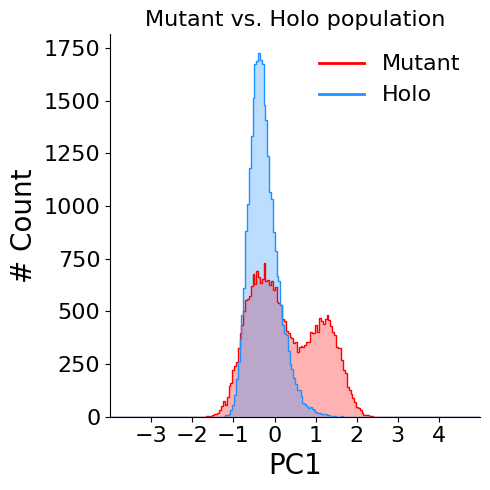

In [16]:
fig, ax = plt.subplots(1,1, figsize=(5,5), sharey=True, sharex=True)

min_pc = -4
max_pc = 5

sns.despine()
ax.set_xlim([min_pc,max_pc])
ax.set_xticks([-3,-2,-1,0,1,2,3,4])
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.set_xlabel("PC1", fontsize=20)
ax.set_ylabel("# Count", fontsize=20)

a = 'green'
h = 'dodgerblue'
m = 'red'

# ax.hist(red_dim_coords_tot[0:index_apo_end,0], color='green', range=(min_pc, max_pc), bins=n_bins, histtype="step")
# ax.hist(red_dim_coords_tot[0:index_apo_end,0], color='green', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

# ax.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='dodgerblue', range=(min_pc, max_pc), bins=n_bins, histtype="step")
# ax.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='dodgerblue', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

ax.hist(red_dim_coords_mtot[0:index_apo_end,0], color=m, range=(min_pc, max_pc), bins=n_bins, histtype="step")
ax.hist(red_dim_coords_mtot[0:index_apo_end,0], color=m, range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

ax.hist(red_dim_coords_mtot[index_apo_end:index_tot_end,0], color=h, range=(min_pc, max_pc), bins=n_bins, histtype="step")
ax.hist(red_dim_coords_mtot[index_apo_end:index_tot_end,0], color=h, range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

legend_elements = [Line2D([0], [0], color=m, lw=2, label='Mutant'),Line2D([0], [0], color=h, lw=2, label='Holo')]
ax.legend(['Mutant','Holo'], frameon=False, fontsize=16, handles = legend_elements)

ax.set_title("Mutant vs. Holo population", fontsize=16)

fig.tight_layout()
# fig.savefig(output_folder+'/IMAGES/histograms_mut_holo.pdf')
# fig.savefig('histograms_mut_holo.png',dpi=500,bbox_inches='tight')
plt.show()

/tmp/ipykernel_6976/2449378152.py:31: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(['Mutant','Holo'], frameon=False, fontsize=16, handles = legend_elements)


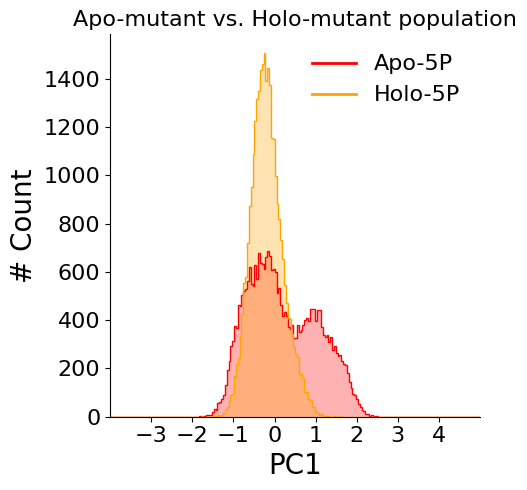

In [19]:
fig, ax = plt.subplots(1,1, figsize=(5,5), sharey=True, sharex=True)

min_pc = -4
max_pc = 5

sns.despine()
ax.set_xlim([min_pc,max_pc])
ax.set_xticks([-3,-2,-1,0,1,2,3,4])
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.set_xlabel("PC1", fontsize=20)
ax.set_ylabel("# Count", fontsize=20)

a = 'green'
h = 'dodgerblue'
m = 'red'
hm = 'orange'

# ax.hist(red_dim_coords_tot[0:index_apo_end,0], color='green', range=(min_pc, max_pc), bins=n_bins, histtype="step")
# ax.hist(red_dim_coords_tot[0:index_apo_end,0], color='green', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

# ax.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='dodgerblue', range=(min_pc, max_pc), bins=n_bins, histtype="step")
# ax.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='dodgerblue', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

ax.hist(red_dim_coords_mtot2[0:index_apo_end,0], color=m, range=(min_pc, max_pc), bins=n_bins, histtype="step")
ax.hist(red_dim_coords_mtot2[0:index_apo_end,0], color=m, range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

ax.hist(red_dim_coords_mtot2[index_apo_end:index_tot_end,0], color=hm, range=(min_pc, max_pc), bins=n_bins, histtype="step")
ax.hist(red_dim_coords_mtot2[index_apo_end:index_tot_end,0], color=hm, range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

legend_elements = [Line2D([0], [0], color=m, lw=2, label='Apo-5P'),Line2D([0], [0], color=hm, lw=2, label='Holo-5P')]
ax.legend(['Mutant','Holo'], frameon=False, fontsize=16, handles = legend_elements)

ax.set_title("Apo-mutant vs. Holo-mutant population", fontsize=16)

fig.tight_layout()
fig.savefig(output_folder+'/IMAGES/histograms_mut_holo.pdf',bbox_inches='tight')
fig.savefig('histograms_apo5p_holo5p.png',dpi=500,bbox_inches='tight')
plt.show()

/tmp/ipykernel_6976/533813785.py:30: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(['Apo','Holo'], frameon=False, fontsize=16, handles = legend_elements)


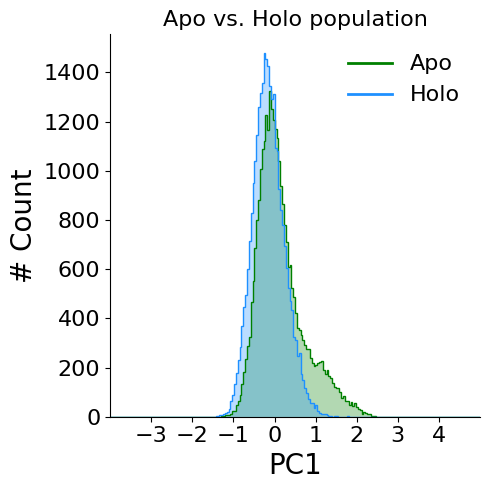

In [20]:
fig, ax = plt.subplots(1,1, figsize=(5,5), sharey=True, sharex=True)

min_pc = -4
max_pc = 5

sns.despine()
ax.set_xlim([min_pc,max_pc])
ax.set_xticks([-3,-2,-1,0,1,2,3,4])
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.set_xlabel("PC1", fontsize=20)
ax.set_ylabel("# Count", fontsize=20)

a = 'green'
h = 'dodgerblue'
m = 'red'

ax.hist(red_dim_coords_tot2[0:index_apo_end,0], color='green', range=(min_pc, max_pc), bins=n_bins, histtype="step")
ax.hist(red_dim_coords_tot2[0:index_apo_end,0], color='green', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

ax.hist(red_dim_coords_tot2[index_apo_end:index_tot_end,0], color='dodgerblue', range=(min_pc, max_pc), bins=n_bins, histtype="step")
ax.hist(red_dim_coords_tot2[index_apo_end:index_tot_end,0], color='dodgerblue', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

# ax.hist(red_dim_coords_mtot[0:index_apo_end,0], color=m, range=(min_pc, max_pc), bins=n_bins, histtype="step")
# ax.hist(red_dim_coords_mtot[0:index_apo_end,0], color=m, range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

# ax.hist(red_dim_coords_mtot[index_apo_end:index_tot_end,0], color=h, range=(min_pc, max_pc), bins=n_bins, histtype="step")
# ax.hist(red_dim_coords_mtot[index_apo_end:index_tot_end,0], color=h, range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

legend_elements = [Line2D([0], [0], color=a, lw=2, label='Apo'),Line2D([0], [0], color=h, lw=2, label='Holo')]
ax.legend(['Apo','Holo'], frameon=False, fontsize=16, handles = legend_elements)

ax.set_title("Apo vs. Holo population", fontsize=16)

fig.tight_layout()
# fig.savefig(output_folder+'/IMAGES/histograms_apo_holo.pdf')
# fig.savefig('histograms_apo_holo.png',dpi=500,bbox_inches='tight')
plt.show()

In [24]:
240*0.26

62.400000000000006

In [21]:
import numpy as np
from scipy.stats import entropy

# Define two probability distributions (can be arrays, lists, or pandas Series)
p = np.array(red_dim_coords_tot2[0:index_apo_end,0])
q = np.array(red_dim_coords_tot2[index_apo_end:index_tot_end,0])

# Manually set bin edges
custom_bin_edges = np.linspace(min(np.min(p), np.min(q)), max(np.max(p), np.max(q)), num=400)

# Compute histograms to estimate the probability distributions
hist1, bin_edges1 = np.histogram(p, bins=custom_bin_edges, density=True)
hist2, bin_edges2 = np.histogram(q, bins=custom_bin_edges, density=True)

# Add a small constant to avoid zero values
epsilon = 1e-10
hist1 = hist1 + epsilon
hist2 = hist2 + epsilon

# Normalize distributions to ensure they sum to 1
hist1 /= np.sum(hist1)
hist2 /= np.sum(hist2)


# Compute KL divergence
kl_divergence1 = entropy(hist1, hist2)
kl_divergence2 = entropy(hist2, hist1)

kl_divergence = (kl_divergence1 + kl_divergence2) / 2

print(f"KL Divergence: {kl_divergence}")

KL Divergence: 0.6657627599310917


In [22]:
# Define two probability distributions (can be arrays, lists, or pandas Series)
p = np.array(red_dim_coords_mtot[0:index_apo_end,0])
q = np.array(red_dim_coords_mtot[index_apo_end:index_tot_end,0])

# Manually set bin edges
custom_bin_edges = np.linspace(min(np.min(p), np.min(q)), max(np.max(p), np.max(q)), num=400)

# Compute histograms to estimate the probability distributions
hist1, bin_edges1 = np.histogram(p, bins=custom_bin_edges, density=True)
hist2, bin_edges2 = np.histogram(q, bins=custom_bin_edges, density=True)

# Add a small constant to avoid zero values
# epsilon = 1e-10
hist1 = hist1 + epsilon
hist2 = hist2 + epsilon

# Normalize distributions to ensure they sum to 1
hist1 /= np.sum(hist1)
hist2 /= np.sum(hist2)


# Compute KL divergence
kl_divergence1 = entropy(hist1, hist2)
kl_divergence2 = entropy(hist2, hist1)

kl_divergence = (kl_divergence1 + kl_divergence2) / 2

print(f"KL Divergence Mutant: {kl_divergence}")

KL Divergence Mutant: 1.7841582987297082


In [23]:
# Define two probability distributions (can be arrays, lists, or pandas Series)
p = np.array(red_dim_coords_mtot2[0:index_apo_end,0])
q = np.array(red_dim_coords_mtot2[index_apo_end:index_tot_end,0])

# Manually set bin edges
custom_bin_edges = np.linspace(min(np.min(p), np.min(q)), max(np.max(p), np.max(q)), num=400)

# Compute histograms to estimate the probability distributions
hist1, bin_edges1 = np.histogram(p, bins=custom_bin_edges, density=True)
hist2, bin_edges2 = np.histogram(q, bins=custom_bin_edges, density=True)

# Add a small constant to avoid zero values
# epsilon = 1e-10
hist1 = hist1 + epsilon
hist2 = hist2 + epsilon

# Normalize distributions to ensure they sum to 1
hist1 /= np.sum(hist1)
hist2 /= np.sum(hist2)


# Compute KL divergence
kl_divergence1 = entropy(hist1, hist2)
kl_divergence2 = entropy(hist2, hist1)

kl_divergence = (kl_divergence1 + kl_divergence2) / 2

print(f"KL Divergence Mutant Apo-Holo: {kl_divergence}")

KL Divergence Mutant Apo-Holo: 1.8505326255700771


<ipython-input-7-7d736d3aa5b7>:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(['Apo','Holo'], frameon=False, fontsize=16, handles = legend_elements)


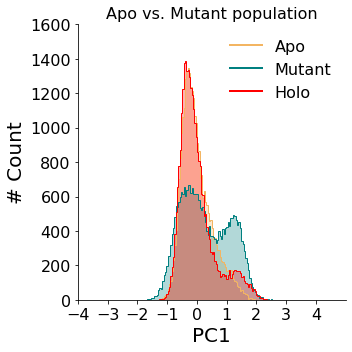

In [7]:
fig, ax = plt.subplots(1,1, figsize=(5,5), sharey=True, sharex=True)

min_pc = -4
max_pc = 5

sns.despine()
ax.set_xlim([min_pc,max_pc])
ax.set_ylim([0,1600])
ax.set_xticks([-4,-3,-2,-1,0,1,2,3,4])
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.set_xlabel("PC1", fontsize=20)
ax.set_ylabel("# Count", fontsize=20)

ax.hist(red_dim_coords_tot[0:29400,0], color='#F3B562', range=(min_pc, max_pc), bins=n_bins, histtype="step")
ax.hist(red_dim_coords_tot[0:29400,0], color='#F3B562', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

ax.hist(red_dim_coords_tot[29401:58800,0], color='teal', range=(min_pc, max_pc), bins=n_bins, histtype="step")
ax.hist(red_dim_coords_tot[29401:58800,0], color='teal', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

# ax.hist(red_dim_coords_tot[58801:88200,0], color='red', range=(min_pc, max_pc), bins=n_bins, histtype="step")
# ax.hist(red_dim_coords_tot[58801:88200,0], color='red', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

ax.hist(red_dim_coords_apo[:,0], color='red', range=(min_pc, max_pc), bins=n_bins, histtype="step")
ax.hist(red_dim_coords_apo[:,0], color='red', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

legend_elements = [Line2D([0], [0], color='#F3B562', lw=2, label='Apo'),Line2D([0], [0], color='teal', lw=2, label='Mutant'),Line2D([0], [0], color='red', lw=2, label='Holo')]
ax.legend(['Apo','Holo'], frameon=False, fontsize=16, handles = legend_elements)
ax.set_title("Apo vs. Mutant population", fontsize=16)

fig.tight_layout()
fig.savefig(output_folder+'/IMAGES/histograms_apo_pc_cert_holo_0t.pdf')
plt.show()

### Clustering


In [11]:
clone_apo = CLoNe(pdc=10)
clone_holo = CLoNe(pdc=pdc)
clone_apoholo = CLoNe(pdc=6)

clone_apo.fit(red_dim_coords_tot[0:index_apo_end,0].reshape(-1, 1)) 
clone_holo.fit(red_dim_coords_tot[index_apo_end:index_tot_end,0].reshape(-1, 1)) 
#clone_apoholo.fit(red_dim_coords_tot[:,3].reshape(-1, 1))   

Unique cluster found with set parameters.


KeyboardInterrupt: 

In [3]:
vol_wt = np.loadtxt('stard11_apo_allatom_in_water/pocket/mdpout_descriptors.txt', skiprows=1, unpack=True)
vol_mut = np.loadtxt('cert_5p/pocket/mdpout_descriptors.txt', skiprows=1, unpack=True)
vol_tot = [[],[]]
vol_tot[0] = vol_wt[1]
vol_tot[1] = vol_mut[1]

In [4]:
print (vol_tot)

[array([1262.59, 1617.83, 1510.92, ..., 1402.24, 1472.05, 1128.69]), array([1204.99, 1285.99, 1394.39, ...,  932.96,  922.21,  863.36])]


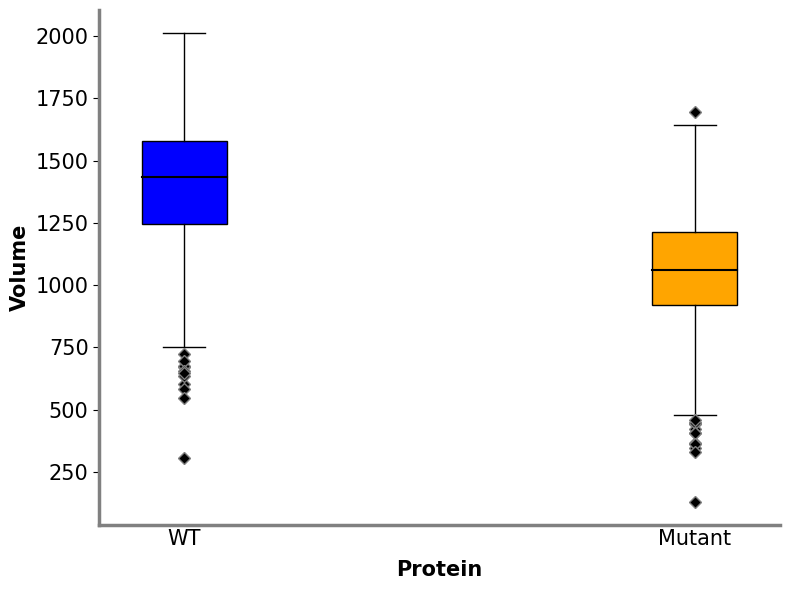

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

medianprops = dict(color="black",linewidth=1.5)
names = ["WT","Mutant"]
colors = ["blue", "orange", "green", "red", "purple"]
for i in range(2):
    protein_data = vol_tot[i]
    
    bp = ax.boxplot(protein_data, positions=[i * 3 +1], 
                    widths=0.5, patch_artist=True, medianprops=medianprops, flierprops={'marker': 'D', 'markerfacecolor': 'black', 'markeredgecolor': 'gray'},
                    boxprops=dict(facecolor=colors[i]))
    
    # Set facecolor of boxes
    # patch.set_facecolor(colors[i])
    
    
    ax.set_xticks([])  
    ax.tick_params(left=True, labelsize = 15, length = 4)
    
    ax.text((i * 3 + 1), -45, names[i], rotation=0, ha='center', fontsize=15)
    
    # Set labels and title
    ax.set_xlabel('Protein',labelpad=25, x=0.5, fontsize=15, fontweight='bold')
    ax.set_ylabel('Volume', fontsize = 15, fontweight='bold')
    #ax.set_title('Interaction of the Domains with the PM',fontsize = 15)
    
    # Draw vertical dashed line after every three boxplots
    # if i < len(proteins) - 1:
    #     ax.axvline((i + 1) * 3 + 0.5, color='gray', linestyle='--')

# Create custom legend
#legend_labels = ['Unmodified', '\u03BB_PW = 1.10', '\u03BB_PP = 0.88']
# legend_labels = ['Unmodified', '$\u03BB_{PW}$ = 1.10', '$\u03BB_{PP}$ = 0.88']
# legend_handles = [plt.Rectangle((0,0),1,1,fc=color) for color in colors]
# ax.legend(legend_handles, legend_labels, loc='upper left', fontsize = 22)

ax.spines['left'].set_linewidth(2.5)  
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['left'].set_color('gray') 
ax.spines['bottom'].set_color('gray')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()

#plt.ylim([0,100])
plt.show()

fig.savefig("Volume_STARD11.png", dpi=400, bbox_inches = 'tight')

# Population analysis

In [9]:
clusters = np.unique(clone_apoholo.labels_)
labels_apo = clone_apoholo.labels_[0:index_apo_end]
labels_holo = clone_apoholo.labels_[index_apo_end:index_tot_end]
pop_list = []
for label in clusters:
    
    count_apo = np.count_nonzero(labels_apo == label)
    count_holo = np.count_nonzero(labels_holo == label)
    count_tot= np.count_nonzero(clone_apoholo.labels_[0:index_tot_end] == label)
    pop_list.append([label, count_apo/count_tot*100, count_holo/count_tot*100, count_tot/len(clone_apoholo.labels_)*100])
    #print(label, count_apo, count_holo, count_tot)

df = pd.DataFrame(pop_list, columns=['cluster', 'frames apo (%)', 'frames holo (%)', 'cluster relevance (%)'])  

df.to_csv(output_folder+'/'+tot_name+"_1/population_analysis.txt", sep=" ", float_format="%2.2f")

NameError: name 'clone_apoholo' is not defined

# Cluster plots

/Users/andrea/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


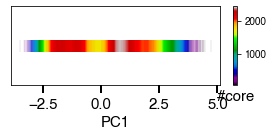

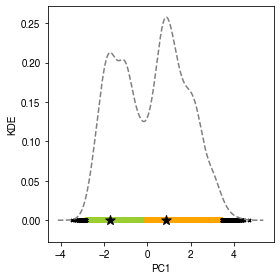

In [16]:
pca_headers = ["PC%i"%(x + 1) for x in range(n_pca)]
plot_clusters(clone_apo, red_dim_coords_tot[0:index_apo_end,0].reshape(-1, 1), output_folder+'/apo_1',pca_headers[:2] ) 
#plot_clusters(clone_holo, red_dim_coords_tot[index_apo_end:index_tot_end,0].reshape(-1, 1), output_folder+'/holo_1',pca_headers[:2] )
#plot_clusters(clone_apoholo, red_dim_coords_tot[:,3].reshape(-1, 1), output_folder+'/'+tot_name+'_1',pca_headers[:2] )

# Save clusters

In [11]:
# Load trajectories
struct_apo = mdtraj.load(trj_apo, top=topo_apo)
struct_holo = mdtraj.load(trj_holo, top=topo_apo)
struct_apoholo = mdtraj.load(trj_tot, top=topo_apo)

In [12]:
unique_labels = range(len(clone_apoholo.centers)) 
folder = output_folder+'/'+tot_name+'_1'

# Save center
[struct_apoholo[center].save(folder+"/Center_%d.pdb"%(center_id + 1)) for center, center_id in zip(clone_apoholo.centers, unique_labels)]
# Save trajs
[struct_apo[clone_apoholo.labels_[0:index_apo_end] == lab].save(folder+"/Cluster_apo_%d.xtc"%(lab + 1)) for lab in unique_labels]
[struct_holo[clone_apoholo.labels_[index_apo_end:] == lab].save(folder+"/Cluster_holo_%d.xtc"%(lab + 1)) for lab in unique_labels]

[None, None, None]

# Save extreme structures

In [13]:
minframe=[100,-1,-2]
maxframe=[-100,-1,-2]
for frame in zip(red_dim_coords_tot[:,0].reshape(-1, 1), clone_apoholo.labels_, range(len(clone_apoholo.labels_))):
    if frame[1] != -1:
        if frame[0] < minframe[0]:
            minframe = frame
        if frame[0] > maxframe[0]:
            maxframe = frame

folder = output_folder+'/'+tot_name+'_1'
struct_apoholo[minframe[2]].save(folder+"/extremeleft.pdb")          
struct_apoholo[maxframe[2]].save(folder+"/extremeright.pdb")          


In [53]:
a = sorted(zip(red_dim_coords_tot[:,0].reshape(-1, 1), clone_apoholo.labels_, range(len(clone_apoholo.labels_))))
a = [el for el in a if el[1] != -1]
a[0]
struct_apoholo[a[0][2]].save(folder+"/extremeleft1.pdb")
struct_apoholo[a[1][2]].save(folder+"/extremeleft2.pdb")
struct_apoholo[a[2][2]].save(folder+"/extremeleft3.pdb")
struct_apoholo[a[3][2]].save(folder+"/extremeleft4.pdb")
struct_apoholo[a[4][2]].save(folder+"/extremeleft5.pdb")

struct_apoholo[a[-1][2]].save(folder+"/extremeright1.pdb")
struct_apoholo[a[-2][2]].save(folder+"/extremeright2.pdb")
struct_apoholo[a[-3][2]].save(folder+"/extremeright3.pdb")
struct_apoholo[a[-4][2]].save(folder+"/extremeright4.pdb") 
struct_apoholo[a[-5][2]].save(folder+"/extremeright5.pdb")

 # Save  PC in B-fact

In [15]:
folder = output_folder
struct_apo = mdtraj.load("../mdm12_monomer_disulf_resid28-213_whichis_resid28-244incrystal/apo_wt_ca.xtc", top="../mdm12_monomer_disulf_resid28-213_whichis_resid28-244incrystal/apo_ca.gro")
bfact_apo = np.append(np.append(np.zeros(15),np.insert(np.insert(calc_magn_vector(pca_apo.components_[0]),60,[0]*11),137,[0]*30)),np.zeros(6))
bfact_holo = np.append(np.append(np.zeros(15),np.insert(np.insert(calc_magn_vector(pca_holo.components_[0]),60,[0]*11),137,[0]*30)),np.zeros(6))
bfact_tot = np.append(np.append(np.zeros(15),np.insert(np.insert(calc_magn_vector(pca_tot.components_[0]),60,[0]*11),137,[0]*30)),np.zeros(6))
struct_apo[0].save_pdb("apo_PCA.pdb", bfactors=bfact_apo*100)
struct_apo[0].save_pdb("mut_PCA.pdb", bfactors=bfact_holo*100)
struct_apo[0].save_pdb("tot_PCA.pdb", bfactors=bfact_tot*100)